In [1]:
import os
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import labelme
import math
from skimage.transform import resize
from skimage import img_as_ubyte
import random

%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils, visualize
import mrcnn.model as modellib
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "datasets", "cstr")

# Image size info
IMAGE_HEIGHT = 480
IMAGE_WIDTH = 640

# Class names
CLASS_NAMES = [
    'worker-formwork',
    'worker-concrete',
    'worker-welding',
    'worker-rebar',
    'worker-scaffolding',
    'worker-dump',
    'worker-heavy',
    'worker-aerial',
    'worker-other',
    'worker-idle',
    'rebar-bs',
    'rebar-wc',
    'rebar-material',
    'steel',
    'concrete-pouring',
    'concrete-forming',
    'formwork-bs',
    'formwork-wc',
    'formwork-material',
    'scaffolding',
    'excavator',
    'bulldozer',
    'dump-truck',
    'concrete-bucket',
    'concrete-mixer',
    'concrete-pump',
    'tower-crane',
    'crane',
    'basket',
    'machine-other'
]

Using TensorFlow backend.


In [2]:
# Visualize annotations
for filename in np.random.choice(os.listdir(IMAGE_DIR), 2):
    print(filename)
    data = json.load(open(os.path.join(IMAGE_DIR, filename)))
    # show annotated image
    img = labelme.utils.img_b64_to_array(data['imageData'])
    print(img.shape)  # (480, 640, 3)
    plt.imshow(img)
    plt.show()
    lbl, lbl_names = labelme.utils.labelme_shapes_to_label(img.shape, data['shapes'])
    lbl_viz = labelme.utils.draw_label(lbl, img, lbl_names)
    plt.imshow(lbl_viz)
    plt.show()

    # transfer annotation from polygon to binary mask
    for item in data['shapes']:
        mask = labelme.utils.polygons_to_mask(img.shape, item['points'])
        plt.title(item['label'])
        plt.imshow(mask)
        plt.show()

train


IsADirectoryError: [Errno 21] Is a directory: '/home/wanyingge/Mask_RCNN/datasets/cstr/train'

In [3]:
# Configurations

class CstrConfig(Config):
    """Configuration for training on the construction site images dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cstr"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 2
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 30  # background + 30 different labels

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    # STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    # VALIDATION_STEPS = 5
    
config = CstrConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[160 160]
 [ 80  80]
 [ 40  40]
 [ 20  20]
 [ 10  10]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      2
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_MIN_DIM                  480
IMAGE_PADDING                  True
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cstr
NUM_CLASSES                    31
POOL_SIZE                      7
POST_NMS_ROIS_INFER

In [4]:
# Dataset

class CstrDataset(utils.Dataset):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:
    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...
    See COCODataset and ShapesDataset as examples.
    """
    def add_image(self, source, image_id, image, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "image": image,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)
        
    def load_data(self, image_dir, class_names, train=True, val_rate=0.3):
        """Load a subset of the COCO dataset.
        image_dir: The root directory of the construction site images dataset.
        val_rate: The portion of validation set of the whole dataset
        """
#         num_image = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])
        num_image = 3590
        
        if train:
            id_start = 1
            id_end = int(num_image * (1 - val_rate)) + 1
        else:
            id_start = int(num_image * (1 - val_rate)) + 1
            id_end = num_image + 1
        
        for image_id in range(id_start, id_end):
#             print(os.path.join(IMAGE_DIR, '{0:05d}'.format(image_id) + '.json'))
#             print(os.path.exists(os.path.join(IMAGE_DIR, '{0:05d}'.format(image_id) + '.json')))
            data = json.load(open(os.path.join(image_dir, '{0:05d}'.format(image_id) + '.json')))
            image_float = resize(labelme.utils.img_b64_to_array(data['imageData']), [IMAGE_HEIGHT, IMAGE_WIDTH])
            self.add_image(
                "cstr",
                image_id=image_id,
                image=img_as_ubyte(image_float),
                shapes=data['shapes'])

        # Add classes
        for i in range(len(class_names)):
            self.add_class("cstr", i, class_names[i])
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
#         if image.ndim != 3:
#             image = skimage.color.gray2rgb(image)
        return self.image_info[image_id]["image"]

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        shapes = image_info['shapes']
        image_data = image_info['image']
        count = len(shapes)
        mask = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, count], dtype=np.bool)
        class_names = []
        for i, region in enumerate(shapes):
            temp = resize(labelme.utils.polygons_to_mask(image_data.shape, region['points']), [IMAGE_HEIGHT, IMAGE_WIDTH])
            mask[:, :, i:i+1] = temp.reshape([IMAGE_HEIGHT, IMAGE_WIDTH, 1])
            class_names.append(region['label'])
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(class_name) for class_name in class_names])
        return mask, class_ids

In [5]:
# Training dataset
dataset_train = CstrDataset()
dataset_train.load_data(IMAGE_DIR + '/train', CLASS_NAMES, train=True)
dataset_train.prepare()

# Validation dataset
dataset_val = CstrDataset()
dataset_val.load_data(IMAGE_DIR + '/val', CLASS_NAMES, train=False)
dataset_val.prepare()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


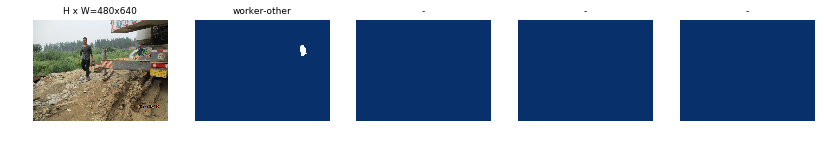

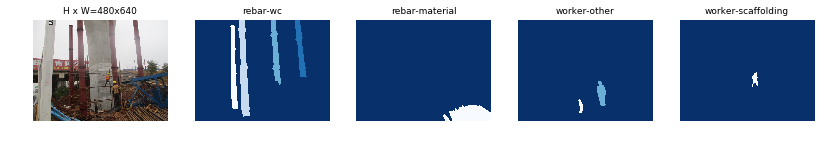

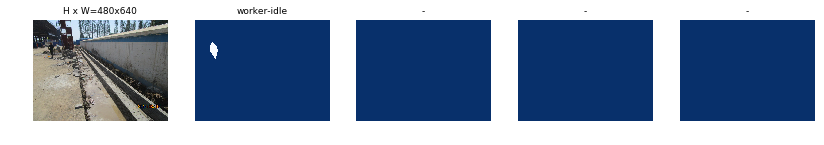

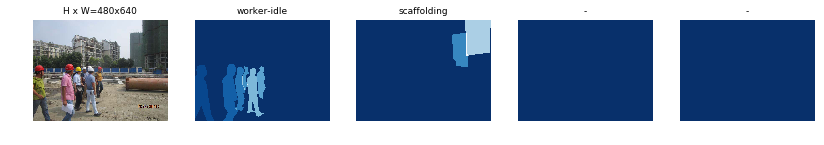

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [9]:
# *** This training schedule is an example. Update to your needs ***

# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=4,  # 40
            layers='heads')

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=12,  # 120
            layers='4+')

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=16,  # 160
            layers='all')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/wanyingge/Mask_RCNN/logs/cstr20180412T1459/mask_rcnn_cstr_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/wanyingge/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
  63/1000 [>.............................] - ETA: 11:08 - loss: 3.7741 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.7079 - mrcnn_class_loss: 1.3970 - mrcnn_bbox_loss: 0.8255 - mrcnn_mask_loss: 0.7852

Process Process-2:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "model", "mask_rcnn_cstr.h5")
# model.keras_model.save_weights(model_path)

In [16]:
class InferenceConfig(CstrConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/wanyingge/logs/cstr20180411T1507/mask_rcnn_cstr_0016.h5


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


original_image           shape: (640, 640, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (39,)                 min:    0.00000  max:  640.00000
gt_class_id              shape: (2,)                  min:   10.00000  max:   12.00000
gt_bbox                  shape: (2, 4)                min:  216.00000  max:  625.00000
gt_mask                  shape: (640, 640, 2)         min:    0.00000  max:    1.00000


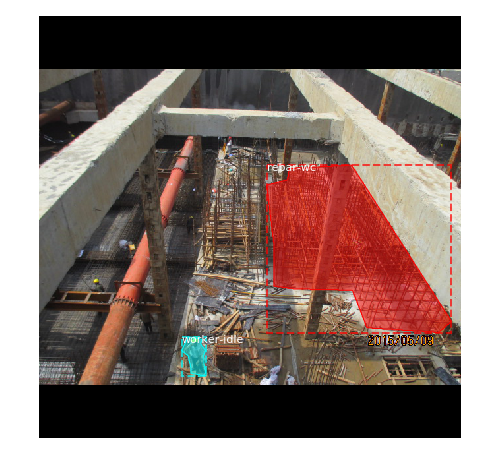

In [41]:
# Test on a random image

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 39)               min:    0.00000  max:  640.00000


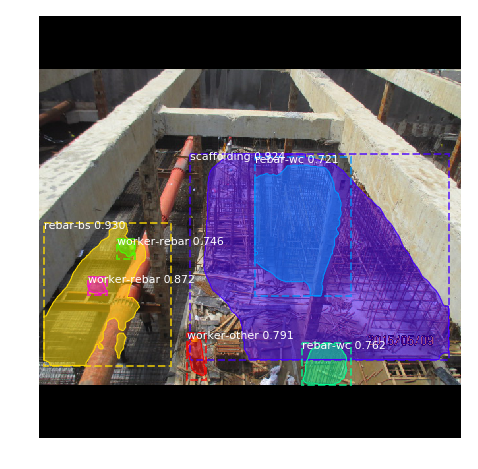

In [42]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [33]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


mAP:  0.280306128306
